In [1]:
import glob
import calendar

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from xskillscore import pearson_r
import xesmf as xe
import cartopy
import cartopy.crs as ccrs

In [2]:
obs_files = sorted(glob.glob("/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_*.nc"))

In [3]:
baseline_start = "1985-01-01"
baseline_end = "2014-12-31"
future_start = "2070-01-01"
future_end = "2099-12-31"

In [30]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Geraldton': (-28.8, 114.6),
    'Perth': (-32.0, 115.9),
    'Port Augusta': (-32.5, 137.8),
    'Adelaide': (-34.9, 138.6),
}

# Seasonal cycle bias

In [5]:
ds_obs = xr.open_mfdataset(obs_files)
ds_obs = ds_obs.sel(time=slice(baseline_start, baseline_end))
ds_obs = ds_obs.rename({'precip': 'pr'})

In [6]:
obs_monthly_mean = ds_obs['pr'].groupby('time.month').mean('time')
obs_annual = ds_obs['pr'].resample(time='Y').sum()
obs_annual_mean = obs_annual.mean('time')
obs_monthly_annual_pct = (obs_monthly_mean / obs_annual_mean) * 100
obs_monthly_annual_pct = obs_monthly_annual_pct.compute()

In [7]:
model_files = {
    'ACCESS-CM2': ['/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/Amon/pr/gn/v20210607/pr_Amon_ACCESS-CM2_historical_r4i1p1f1_gn_185001-201412.nc',],
    'ACCESS-ESM1-5': ['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/Amon/pr/gn/v20200529/pr_Amon_ACCESS-ESM1-5_historical_r6i1p1f1_gn_185001-201412.nc',],
    'CESM2': ['/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/pr/gn/v20190514/pr_Amon_CESM2_historical_r11i1p1f1_gn_195001-199912.nc', '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/pr/gn/v20190514/pr_Amon_CESM2_historical_r11i1p1f1_gn_200001-201412.nc'],
    'CMCC-ESM2': ['/g/data/oi10/replicas/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/Amon/pr/gn/v20210114/pr_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc',],
}

In [8]:
def model_correlation(hist_files):
    """Calculate correlation between model and obs monthly climatology"""

    ds_hist = xr.open_mfdataset(hist_files)
    ds_hist = ds_hist.sel(time=slice(baseline_start, baseline_end))
    ds_hist['pr'] = (ds_hist['pr'] * 86400) * ds_hist['time'].dt.days_in_month
    ds_hist['pr'].attrs['units'] = 'mm'
    
    regridder = xe.Regridder(ds_hist, obs_monthly_mean, 'bilinear')
    ds_hist_regridded = regridder(ds_hist)
    
    hist_monthly_mean = ds_hist_regridded['pr'].groupby('time.month').mean('time')
    hist_annual = ds_hist_regridded['pr'].resample(time='Y').sum()
    hist_annual_mean = hist_annual.mean('time')
    hist_monthly_annual_pct = (hist_monthly_mean / hist_annual_mean) * 100
    hist_monthly_annual_pct = hist_monthly_annual_pct.compute()
    
    corr = pearson_r(obs_monthly_annual_pct, hist_monthly_annual_pct, 'month')
    corr = corr.compute()
    
    return corr, hist_monthly_annual_pct

In [9]:
corr_dict = {}
model_dict = {}

for model in ['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CMCC-ESM2']:
    corr_dict[model], model_dict[model] = model_correlation(model_files[model])

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/dat

In [26]:
def plot_cities(ax, label_color='green'):
    lats = [-27.4705, -37.8, -32.5] 
    lons = [153.0260, 145.0, 137.8]
    cities = ['Brisbane', 'Melbourne', 'Port Augusta']
    offsets = {'Brisbane': -8.5, 'Melbourne': 0.7, 'Port Augusta': 1.0}
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'go', zorder=5, transform=ccrs.PlateCarree())
        ax.text(lon + offsets[city], lat, city, fontsize='large', color=label_color,
                transform=ccrs.PlateCarree())

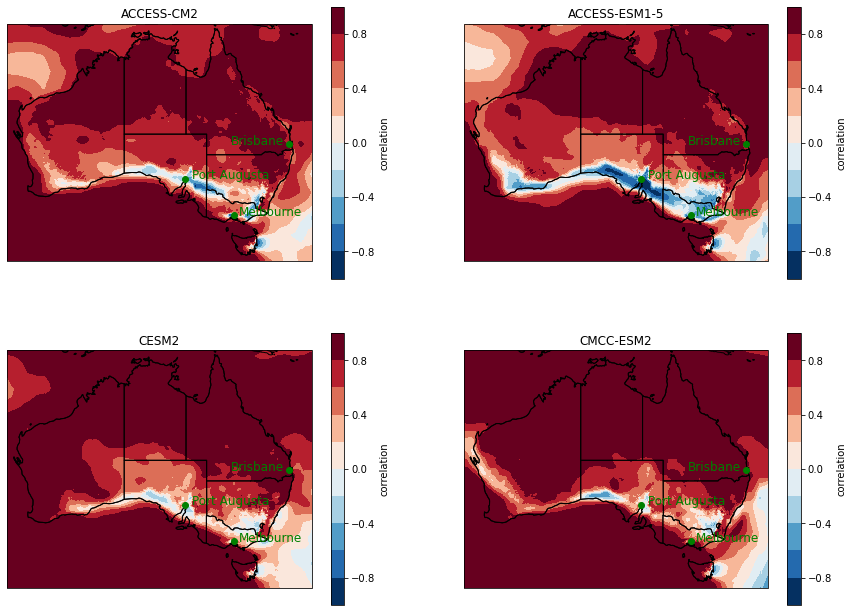

In [27]:
fig = plt.figure(figsize=[15, 11])
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())

levels = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]
cmap = 'RdBu_r'
cbar = {'label': 'correlation'}

corr_dict['ACCESS-CM2'].plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs=cbar, levels=levels)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
plot_cities(ax1)
ax1.set_title('ACCESS-CM2')

corr_dict['ACCESS-ESM1-5'].plot(ax=ax2, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs=cbar, levels=levels)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
plot_cities(ax2)
ax2.set_title('ACCESS-ESM1-5')

corr_dict['CESM2'].plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs=cbar, levels=levels)
ax3.coastlines()
ax3.add_feature(cartopy.feature.STATES)
plot_cities(ax3)
ax3.set_title('CESM2')

corr_dict['CMCC-ESM2'].plot(ax=ax4, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs=cbar, levels=levels)
ax4.coastlines()
ax4.add_feature(cartopy.feature.STATES)
plot_cities(ax4)
ax4.set_title('CMCC-ESM2')

plt.savefig('pr_correlation.png', bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

In [28]:
def plot_location(ax, city):
    """Plot seasonal cycle for a city"""
    
    lat, lon = city_lat_lon[city]
    
    obs_loc = obs_monthly_annual_pct.sel(lat=lat, lon=lon, method='nearest')
    model_loc = {
        'ACCESS-CM2': model_dict['ACCESS-CM2'].sel(lat=lat, lon=lon, method='nearest'),
        'ACCESS-ESM1-5': model_dict['ACCESS-ESM1-5'].sel(lat=lat, lon=lon, method='nearest'),
        'CESM2': model_dict['CESM2'].sel(lat=lat, lon=lon, method='nearest'),
        'CMCC-ESM2': model_dict['CMCC-ESM2'].sel(lat=lat, lon=lon, method='nearest'),
    }
    ax.plot(xticks, obs_loc, label='AGCD', marker='o', color='black', linewidth=2.0)
    ax.plot(xticks, model_loc['ACCESS-CM2'], label='ACCESS-CM2', marker='o')
    ax.plot(xticks, model_loc['ACCESS-ESM1-5'], label='ACCESS-ESM1-5', marker='o')
    ax.plot(xticks, model_loc['CESM2'], label='CESM2', marker='o')
    ax.plot(xticks, model_loc['CMCC-ESM2'], label='CMCC-ESM2', marker='o')
    
    ax.set_title(city)
    ax.legend()
    ax.set_ylabel('monthly mean precipitation (% of annual mean)')
    ax.set_xticks(xticks, xtick_labels)
    ax.grid()

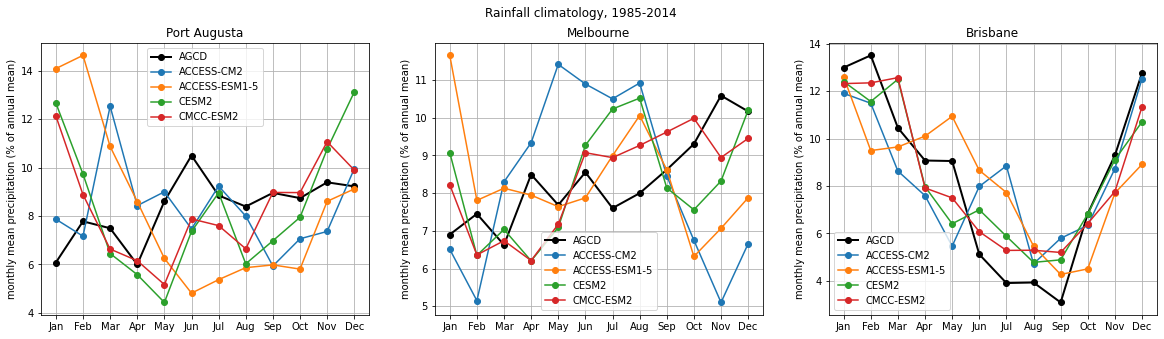

In [31]:
fig = plt.figure(figsize=[20, 5])
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

xticks = np.arange(1, 13)
xtick_labels = [calendar.month_abbr[i] for i in xticks]

plot_location(ax1, 'Port Augusta')
plot_location(ax2, 'Melbourne')
plot_location(ax3, 'Brisbane')

plt.suptitle('Rainfall climatology, 1985-2014') 
plt.savefig('pr_city_cycles.png', bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

# Mean delta change

In [2]:
hist_file = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/pr/gn/v20191115/pr_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc"
ssp_file = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/Amon/pr/gn/v20191115/pr_Amon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_201501-210012.nc"

In [2]:
city = 'Geraldton'

In [4]:
lat, lon = city_lat_lon[city]

In [5]:
ds_obs = xr.open_mfdataset(obs_files)
ds_obs = ds_obs.sel(lat=lat, lon=lon, method='nearest')
ds_obs = ds_obs.sel(time=slice(baseline_start, baseline_end))
ds_obs = ds_obs.rename({'precip': 'pr'})
ds_obs = ds_obs.compute()

In [6]:
ds_hist = xr.open_dataset(hist_file)
ds_hist = ds_hist.sel(lat=lat, lon=lon, method='nearest')
ds_hist = ds_hist.sel(time=slice(baseline_start, baseline_end))
ds_hist['pr'] = (ds_hist['pr'] * 86400) * ds_hist['time'].dt.days_in_month
ds_hist['pr'].attrs['units'] = 'mm'
ds_hist = ds_hist.compute()

In [7]:
ds_future = xr.open_dataset(ssp_file)
ds_future = ds_future.sel(lat=lat, lon=lon, method='nearest')
ds_future = ds_future.sel(time=slice(future_start, future_end))
ds_future['pr'] = (ds_future['pr'] * 86400) * ds_future['time'].dt.days_in_month
ds_future['pr'].attrs['units'] = 'mm'
ds_future = ds_future.compute()

In [8]:
obs_monthly_mean = ds_obs['pr'].groupby('time.month').mean('time')
hist_monthly_mean = ds_hist['pr'].groupby('time.month').mean('time')
future_monthly_mean = ds_future['pr'].groupby('time.month').mean('time')

In [9]:
obs_annual = ds_obs['pr'].resample(time='Y').sum()
hist_annual = ds_hist['pr'].resample(time='Y').sum()
future_annual = ds_future['pr'].resample(time='Y').sum()

In [10]:
obs_annual_mean = obs_annual.mean('time')
hist_annual_mean = hist_annual.mean('time')
future_annual_mean = future_annual.mean('time')

In [11]:
obs_monthly_annual_pct = (obs_monthly_mean.values / obs_annual_mean.values) * 100 
hist_monthly_annual_pct = (hist_monthly_mean.values / hist_annual_mean.values) * 100

### Model change in rainfall

In [12]:
future_annual_mean.values

array(193.16421077)

In [13]:
hist_annual_mean.values

array(323.81530849)

In [14]:
model_rainfall_change = ((future_annual_mean.values - hist_annual_mean.values) / hist_annual_mean.values) * 100
print(f'Modelled change in annual mean rainfall: {model_rainfall_change:.1f}%')

Modelled change in annual mean rainfall: -40.3%


In [15]:
model_rainfall_change_month_pct = ((future_monthly_mean.values - hist_monthly_mean.values) / hist_annual_mean.values) * 100

In [16]:
model_rainfall_change_month_pct.sum()

-40.34741233515578

### Apply delta change method

In [17]:
monthly_adjustment_factors = future_monthly_mean / hist_monthly_mean

In [18]:
da_dc = ds_obs['pr'].groupby('time.month') * monthly_adjustment_factors
da_dc = da_dc.compute()

### Delta change in rainfall

In [19]:
dc_monthly_mean = da_dc.groupby('time.month').mean('time')

In [20]:
dc_annual = da_dc.resample(time='Y').sum()

In [21]:
dc_annual_mean = dc_annual.mean('time')

In [22]:
dc_annual_mean.values

array(279.5149511)

In [23]:
obs_annual_mean.values

array(418.57907, dtype=float32)

In [24]:
dc_rainfall_change = ((dc_annual_mean.values - obs_annual_mean.values) / obs_annual_mean.values) * 100
print(f'Change in annual mean rainfall (delta change method): {dc_rainfall_change:.1f}%')

Change in annual mean rainfall (delta change method): -33.2%


In [25]:
dc_rainfall_change_month_pct = ((dc_monthly_mean.values - obs_monthly_mean.values) / obs_annual_mean.values) * 100

In [26]:
dc_rainfall_change_month_pct

array([ -0.65204874,  -1.26427179,  -2.64542251,  -2.85192781,
        -7.59464158,   1.78338067, -10.7337762 ,  -4.19118645,
        -1.9557637 ,  -2.22917159,  -0.75585957,  -0.13221436])

In [27]:
dc_rainfall_change_month_pct.sum()

-33.222903628007

### Summary plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


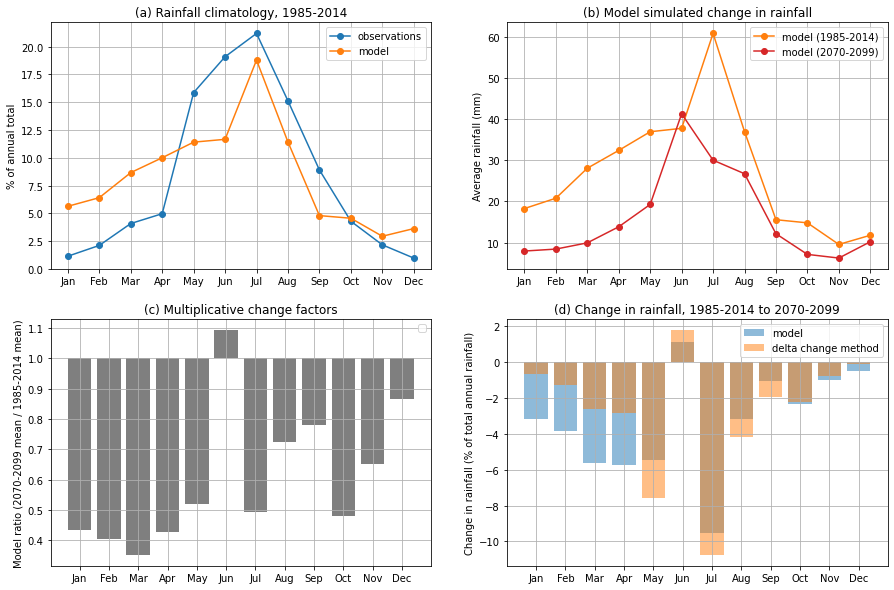

In [29]:
fig = plt.figure(figsize=[15, 10])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

xticks = np.arange(1, 13)
xtick_labels = [calendar.month_abbr[i] for i in xticks]

ax1.plot(xticks, obs_monthly_annual_pct, label='observations', marker='o')
ax1.plot(xticks, hist_monthly_annual_pct, label='model', marker='o')
ax1.set_title('(a) Rainfall climatology, 1985-2014')
ax1.legend()
ax1.set_ylabel('% of annual total')
ax1.set_xticks(xticks, xtick_labels)
ax1.grid()

ax2.plot(xticks, hist_monthly_mean, label='model (1985-2014)', marker='o', color='tab:orange')
ax2.plot(xticks, future_monthly_mean, label='model (2070-2099)', marker='o', color='tab:red')
ax2.set_title('(b) Model simulated change in rainfall')
ax2.legend()
ax2.set_ylabel('Average rainfall (mm)')
ax2.set_xticks(xticks, xtick_labels)
ax2.grid()

ax3.bar(xticks, monthly_adjustment_factors - 1.0, bottom=1.0, color='tab:grey')
ax3.set_title('(c) Multiplicative change factors')
ax3.legend()
ax3.set_ylabel('Model ratio (2070-2099 mean / 1985-2014 mean)')
ax3.set_xticks(xticks, xtick_labels)
ax3.grid()

ax4.bar(xticks, model_rainfall_change_month_pct, alpha=0.5, label='model')
ax4.bar(xticks, dc_rainfall_change_month_pct, alpha=0.5, label='delta change method')
ax4.set_title('(d) Change in rainfall, 1985-2014 to 2070-2099')
ax4.legend()
ax4.set_ylabel('Change in rainfall (% of total annual rainfall)')
ax4.set_xticks(xticks, xtick_labels)
ax4.grid()

#plt.suptitle(city)
plt.savefig(
    f'precip_delta_change_example_{city}.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white',
)